# 第9回 クラスタリングその2: 様々なクラスタリング手法の紹介

いつものように右上の「Remix」ボタンを押して自分用の複製を作成すれば、各セルを「Shift+Enter」で実行しながら読むことができます

編集を行なった後は、Windowsでは「Ctrl+s」、Macでは「Cmd+s」で保存することができます

まず、必要なパッケージを読み込みます

In [1]:
using Plots, CSV, Statistics, LinearAlgebra

# データの作成

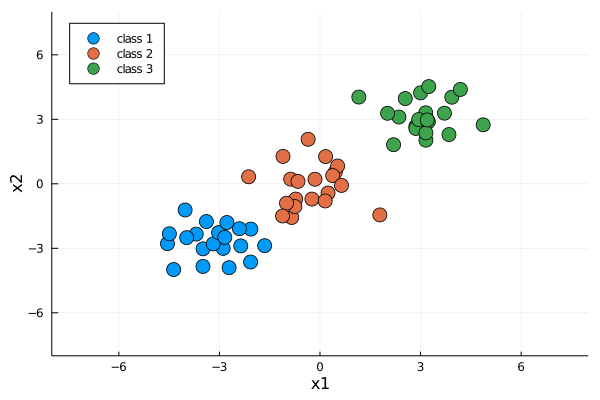

In [1]:
# 3つの正規分布から成るデータを作る
N = 60

x_class1 = randn(Float64, 20, 2) .- 3.0
x_class2 = randn(Float64, 20, 2) .+ 0.0
x_class3 = randn(Float64, 20, 2) .+ 3.0

X = [x_class1; x_class2; x_class3]

scatter(X[1:20, 1], X[1:20, 2], xlims=(-5,6), ylims=(-5,6), markersize=8, label="class 1")

scatter!(X[21:40, 1], X[21:40, 2], xlims=(-5,6), ylims=(-5,6), markersize=8, label="class 2")

scatter!(X[41:60, 1], X[41:60, 2], xlims=(-8,8), ylims=(-8,8), markersize=8, label="class 3", xlabel="x1", ylabel="x2", legend=:topleft)

# 混合ガウスモデル (Gaussian mixture model)

In [1]:
function train_gmm(X, K)
  N, d = size(X)
  # 初期化
  gmm_mu = randn(K, d)
  gmm_covariances = rand(K, d)
  gmm_pi = ones(K) ./ K
  log_prob = zeros(N, K)
  weighted_log_prob = deepcopy(log_prob)
  class = zeros(Int64, N)
  
  for i = 1:1000
    # E-step
    inv_cov = 1.0 ./ sqrt.(gmm_covariances)
    precisions = inv_cov.^2
    log_det = sum(log.(inv_cov), dims=2)
    log_prob .= sum(gmm_mu.^2 .* precisions, dims=2)' .- 2.0 .* (X * (gmm_mu .* precisions)') .+ (X.^2 * precisions')
    weighted_log_prob .=  -0.5 .* (d .* log.(2.0 .* pi) .+ log_prob) .+ log_det' .+ log.(gmm_pi)'
    log_prob_norm = logsumexp(weighted_log_prob, dims=2)
    log_resp = weighted_log_prob .- log_prob_norm

    # M-step
    resp = exp.(log_resp)
    nk = sum(resp, dims=1)
    gmm_mu .= (resp' * X) ./ nk'
    X2 = (resp' * (X .* X)) ./ nk'
    gmm_covariances .= X2 .- gmm_mu.^2
    gmm_pi .= (nk ./ N)[:]
  end

  for n = 1:N
    class[n] = argmax(weighted_log_prob[n, :])
  end

  return class, gmm_pi, gmm_mu, gmm_covariances
end

train_gmm

In [1]:
# K=3として、GMMを行う
class, gmm_pi, gmm_mu, gmm_covariances = train_gmm(X, 3)

([3, 3, 3, 3, 3, 3, 3, 3, 3, 3  …  2, 2, 2, 2, 1, 2, 2, 2, 2, 2], [0.336331, 0.316698, 0.34697], [-0.105808 0.414232; 2.81128 3.19656; -3.11407 -2.54243], [0.390987 0.369001; 0.80482 0.530497; 0.531999 0.645906])

In [1]:
gmm_pi

3-element Array{Float64,1}:
 0.336331
 0.316698
 0.34697

In [1]:
gmm_mu

3×2 Array{Float64,2}:
 -0.105808   0.414232
  2.81128    3.19656
 -3.11407   -2.54243

In [1]:
gmm_covariances

3×2 Array{Float64,2}:
 0.390987  0.369001
 0.80482   0.530497
 0.531999  0.645906

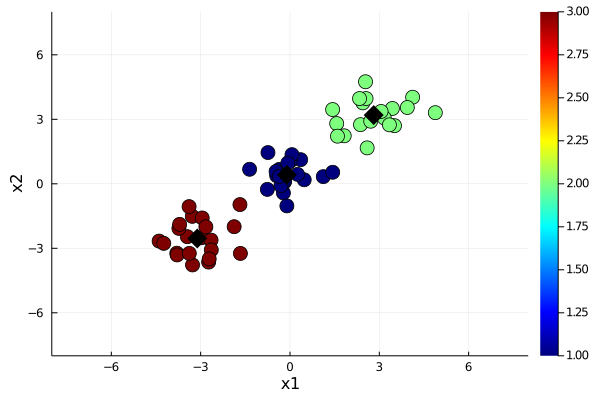

In [1]:
# クラスタの中心と合わせて分類結果をプロット
k = 1
scatter(X[:, 1], X[:, 2], marker_z=class, color=:jet, markersize=8, label=nothing)
scatter!(gmm_mu[:, 1], gmm_mu[:, 2], markershape=:diamond, markersize=10, color=:black, label=nothing, xlims=(-8,8), ylims=(-8,8), xlabel="x1", ylabel="x2", legend=:topleft)


# 階層的なデータ

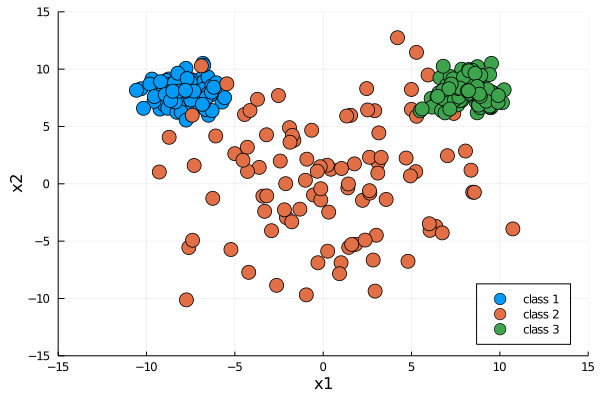

In [1]:
# 3つのサイズが異なる(正規分布の分散が異なる)データを作る
N = 300

x_class1 = randn(Float64, 100, 2)
x_class1[:, 1] .= x_class1[:, 1] .- 8.0
x_class1[:, 2] .= x_class1[:, 2] .+ 8.0

x_class2 = 5.0 .* randn(Float64, 100, 2)

x_class3 = randn(Float64, 100, 2)
x_class3[:, 1] .= x_class3[:, 1] .+ 8.0
x_class3[:, 2] .= x_class3[:, 2] .+ 8.0

x = [x_class1; x_class2; x_class3]

scatter(x[1:100, 1], x[1:100, 2], xlims=(-15,15), ylims=(-15,15), markersize=8, label="class 1")

scatter!(x[101:200, 1], x[101:200, 2], xlims=(-15,15), ylims=(-15,15), markersize=8, label="class 2")

scatter!(x[201:300, 1], x[201:300, 2], xlims=(-15,15), ylims=(-15,15), markersize=8, label="class 3", xlabel="x1", ylabel="x2", legend=:bottomright)

In [1]:
# K=3として、GMMを行う
class, gmm_pi, gmm_mu, gmm_covariances = train_gmm(x, 3)

([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0.340453, 0.339885, 0.319662], [-7.75987 8.00956; 8.00402 7.98188; 0.307865 0.149044], [1.11239 0.970028; 1.18433 1.05374; 18.9394 23.1343])

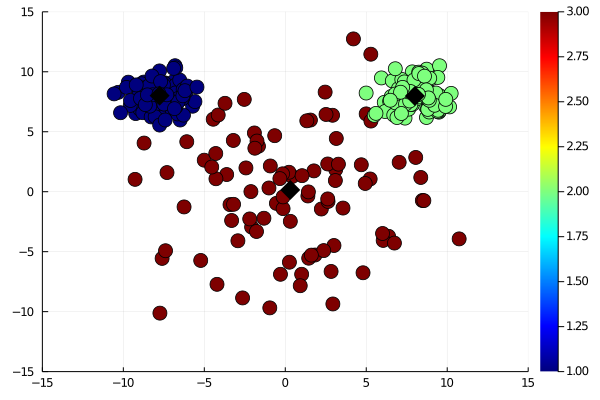

In [1]:
# クラスタの中心と合わせて分類結果をプロット
k = 1
scatter(x[:, 1], x[:, 2], marker_z=class, color=:jet, markersize=8, label=nothing)
scatter!(gmm_mu[:, 1], gmm_mu[:, 2], markershape=:diamond, markersize=10, color=:black, label=nothing, xlims=(-15,15), ylims=(-15,15))
